# Finding the Attack Type using Clustering ( K Means)

In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.manifold import MDS
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [65]:
hulk_df = pd.read_csv('Hulk-NoDefense.csv')
slowhttp_df = pd.read_csv('Slowhttptest-NoDefense.csv')
slowloris_df = pd.read_csv('Slowloris-NoDefense.csv')
tcpflood_df = pd.read_csv('TCPFlood-NoDefense(2).csv')

In [66]:
# checking if columns are the same
hulk_columns = set(hulk_df)
slowhttp_columns = set(slowhttp_df)
slowloris_columns = set(slowloris_df)
tcpflood_columns = set(tcpflood_df)

hulk_columns == slowhttp_columns == slowloris_columns == tcpflood_columns

True

In [67]:
# adding target column
hulk_df['attack_type'] = 'hulk'
slowhttp_df['attack_type'] = 'slow_http'
slowloris_df['attack_type'] = 'slow_loris'
tcpflood_df['attack_type'] = 'tcp_flood'

In [68]:
df = pd.concat([hulk_df,slowhttp_df,slowloris_df,tcpflood_df])
df.sample(5)

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,attack_type
134421,192.168.111.65-192.168.111.66-50217-80-6,192.168.111.65,50217,192.168.111.66,80,6,11/02/2021 09:20:19 AM,52574,25,23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCPFlood-NoDefense,tcp_flood
194153,192.168.111.65-192.168.111.66-60112-80-6,192.168.111.65,60112,192.168.111.66,80,6,11/02/2021 09:06:02 AM,312139,8,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hulk-NoDefense,hulk
32234,192.168.111.65-192.168.111.66-42710-80-6,192.168.111.65,42710,192.168.111.66,80,6,11/02/2021 09:04:14 AM,68935,8,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hulk-NoDefense,hulk
16752,192.168.111.65-192.168.111.66-39976-80-6,192.168.111.65,39976,192.168.111.66,80,6,11/02/2021 09:04:04 AM,114159,7,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hulk-NoDefense,hulk
282590,192.168.111.65-192.168.111.66-42662-80-6,192.168.111.65,42662,192.168.111.66,80,6,11/02/2021 09:07:03 AM,201459,7,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hulk-NoDefense,hulk


In [69]:
df.isna().sum()

Flow ID        0
Src IP         0
Src Port       0
Dst IP         0
Dst Port       0
              ..
Idle Std       0
Idle Max       0
Idle Min       0
Label          0
attack_type    0
Length: 85, dtype: int64

In [70]:

le = LabelEncoder()

print('All possible IPs: ',set(df['Src IP']) | set(df['Dst IP']))

# Encoding IP Addresses


df['Src IP'] = le.fit_transform(df['Src IP'])
df['Dst IP'] = le.fit_transform(df['Dst IP'])


All possible IPs:  {'192.168.111.68', '0.0.0.0', '192.168.111.66', '255.255.255.255', '192.168.111.65', '192.168.111.199', '192.168.111.255', '192.168.111.250', '*.*.*.*', '192.168.111.6'}


In [71]:
df.isna().sum()
# dropping these columns, can later analyse if they are useful
df.drop(columns=['Flow ID','Label','Timestamp'],inplace=True)

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1151492 entries, 0 to 291759
Data columns (total 82 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Src IP                      1151492 non-null  int64  
 1   Src Port                    1151492 non-null  int64  
 2   Dst IP                      1151492 non-null  int64  
 3   Dst Port                    1151492 non-null  int64  
 4   Protocol                    1151492 non-null  int64  
 5   Flow Duration               1151492 non-null  int64  
 6   Total Fwd Packet            1151492 non-null  int64  
 7   Total Bwd packets           1151492 non-null  int64  
 8   Total Length of Fwd Packet  1151492 non-null  float64
 9   Total Length of Bwd Packet  1151492 non-null  float64
 10  Fwd Packet Length Max       1151492 non-null  float64
 11  Fwd Packet Length Min       1151492 non-null  float64
 12  Fwd Packet Length Mean      1151492 non-null  float64
 13

In [73]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=633, shuffle=True)

In [74]:
attack_types = ['hulk','slow_http','slow_loris','tcp_flood']


train_df = train_df.dropna() # drop na values can handle as well


train_df_output = train_df['attack_type']
train_df_input =  train_df.drop(['attack_type'],axis=1)

scaler = MinMaxScaler()
train_df_input = scaler.fit_transform(train_df_input) # min max scaler, ideally need to customize


kmeans = KMeans(n_clusters=len(attack_types))
kmeans = kmeans.fit(train_df_input)




['hulk: red', 'slow_http: blue', 'slow_loris: green', 'tcp_flood: black']


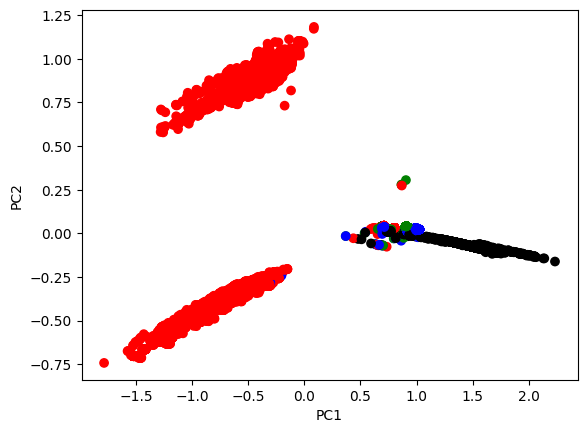

In [75]:
pca = PCA()
x_new = pca.fit_transform(train_df_input)


color_map = {0: 'red', 1: 'blue', 2: 'green', 3: 'black'}
colors = [color_map[attack_types.index(i)] for i in train_df_output]

print([attack_types[i] + ': ' + color_map[i] for i in range(len(attack_types))])
plt.scatter(x_new[:,0], x_new[:,1], c = colors)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

print('Hulk is significantly different from other attacks, also tcp flood is on the extreme end as well')

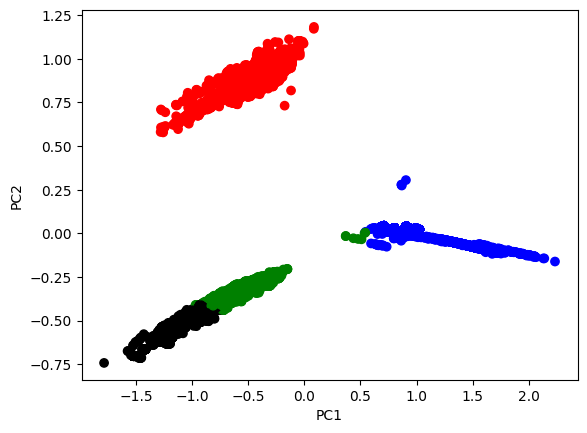

In [76]:

colors = [color_map[i] for i in kmeans.labels_]
plt.scatter(x_new[:,0], x_new[:,1], c = colors)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()